## LGBM & XGBM Assignment: Comparative Analysis of LightGBM and XGBoost on Titanic Dataset:



**Objective**:

The purpose of this assignment is to compare the performance of LightGBM and XGBoost algorithms using the Titanic dataset. This analysis will involve exploratory data analysis, preprocessing, model building, and a comparative evaluation to understand their strengths in survival prediction.



**Dataset**:

The Titanic dataset is used for this analysis, which predicts passenger survival (0 = did not survive, 1 = survived) based on demographic and travel details. Key fields include:



PassengerId: Unique identifier.

Survived: Target variable (0 or 1).

Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).

Name: Passenger name.

Sex: Gender (male/female).

Age: Age in years.

SibSp: Number of siblings/spouses aboard.

Parch: Number of parents/children aboard.

Ticket: Ticket number.

Fare: Passenger fare.

Cabin: Cabin number.

Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).  



**Details**: The training set has 891 records, while the test set has 418, providing a classic binary classification scenario with a mix of numeric and categorical features

**1. Exploratory Data Analysis (EDA)**:



I carried out exploratory data analysis to understand the structure, distributions, and relationships of the dataset in order to set the foundation for successful modeling.





**1.1 Titanic Dataset Loading Using the Pandas Library in Python**:  

I began my analysis by importing the training dataset to look at its initial state and make sure it loaded smoothly.

In [1]:
import pandas as pd

# Load the Titanic training dataset
data = pd.read_csv('Titanic_train.csv')

# Basic check
print("Dataset Shape:", data.shape)
print("First 5 Rows:\n", data.head())
print("Data Types:\n", data.dtypes)

Dataset Shape: (891, 12)
First 5 Rows:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0       

With 891 rows and 12 columns, the dataset loaded successfully and had the expected structure. With Survived as the binary target and missing values in Cabin (e.g., row 0), the first five rows display a typical passenger profile. A variety of numeric and categorical features are confirmed by the data types, which include integers (Survived, Pclass), floats (Age, Fare), and objects (Name, Sex). With categorical variables like Sex and Embarked requiring attention later, this provides a strong basis for additional analysis.

**2. Checking for Missing Values**:

I inspected the dataset for missing values to identify gaps that could impact modeling, ensuring data quality before proceeding.

In [2]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


The dataset has missing values in Age (177, ~20% of rows), Cabin (687, ~77%), and Embarked (2, minimal). Age and Embarked will need imputation, while Cabin’s high missing rate suggests it may be dropped unless it proves valuable. This step highlights the need for careful preprocessing to handle these gaps effectively.

**3. Explore Data Distributions Using Histograms and Box Plots**:

I visualized the distributions of numeric features to identify skewness and outliers, helping to understand the data's spread and potential preprocessing needs.

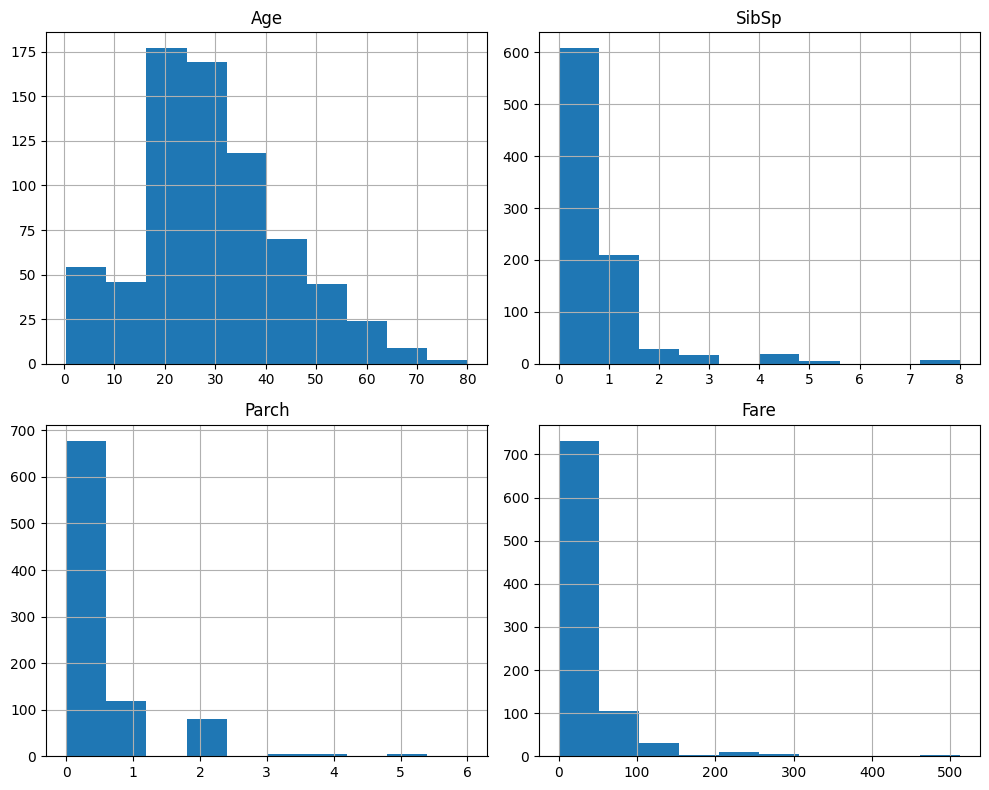

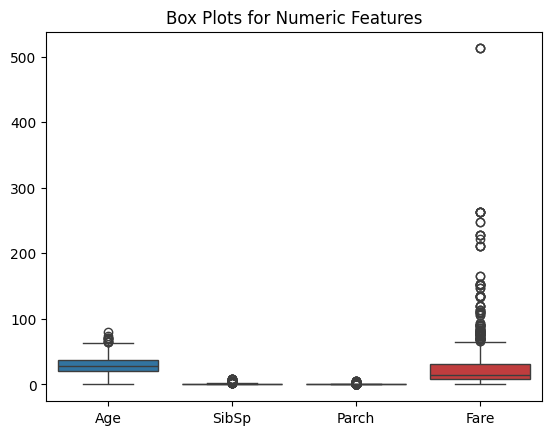

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numeric features
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
data[numeric_cols].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

# Box plots for outliers
sns.boxplot(data=data[numeric_cols])
plt.title('Box Plots for Numeric Features')
plt.show()

I see in the histograms that Age is roughly normal with a peak between 20 and 30 and a slight right skew, though there are some outliers over 60. With few larger families and the majority of passengers having 0 or 1 relative on board, SibSp and Parch are highly skewed. With most values below 100 and a few outliers exceeding 500, the fare is wildly skewed to the right. These trends are supported by the boxplots, which show outliers in Age (above 60) and Fare in particular that might profit from capping or log transformation. Future feature engineering will be guided by these insights, which show dataset variability with Fare probably linked to survival and class.

**4. Visualize Relationships Between Features and Survival Using Scatter Plots and Bar Plots**:  

I explored relationships between key features and survival to identify patterns that might influence the predictive models, focusing on Pclass and Age vs. Fare.

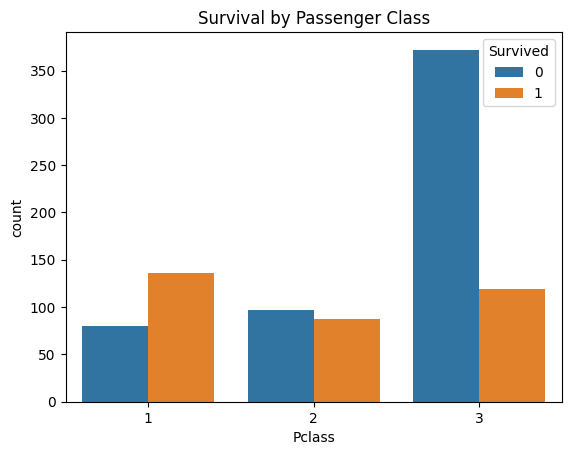

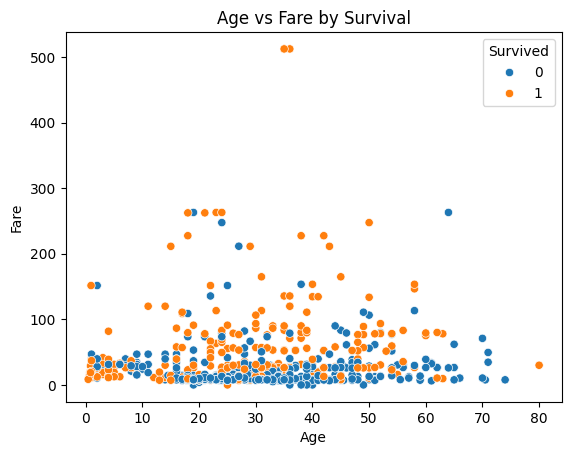

In [4]:
# Bar plot for Pclass vs Survived
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Survival by Passenger Class')
plt.show()

# Scatter plot for Age vs Fare colored by Survived
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=data)
plt.title('Age vs Fare by Survival')
plt.show()

The Age vs Fare scatter plot colored by Survival shows that survivors (orange) are the ones that spread out at the higher Fares, while non-survivors (blue) are those that form a more compact group at the lower Fares for all ages. Alone, Age does not show any survival pattern, but Fare looks like the variable that separates the survival chances. The bar plot of Survival by Passenger Class tells the story that the passengers of the first class were the ones who had the highest rates of survival, while the third-class passengers were those who had the lowest, and thus most of them were the ones who didn't survive. The results here reinforce the idea that Pclass and Fare are two of the most potent variables for the prediction of survival, whereas Age may still be interplaying with other features but is less significant when considered separately.

**2. Data Preprocessing**

I preprocessed the dataset to handle missing values, encode categorical variables, and apply additional methods to prepare it for modeling with LightGBM and XGBoost.

**2.1. Impute Missing Values**:

To maintain data integrity for the models, missing values in the dataset were addressed, with an emphasis on Age, Embarked, and Cabin.

In [12]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Impute missing values
imputer_age = SimpleImputer(strategy='median')
data['Age'] = imputer_age.fit_transform(data[['Age']])

imputer_embarked = SimpleImputer(strategy='most_frequent')
data['Embarked'] = imputer_embarked.fit_transform(data[['Embarked']]).ravel()

# Safely drop Cabin if it exists
data = data.drop('Cabin', axis=1, errors='ignore')

print("Missing Values After Imputation:\n", data.isnull().sum())


Missing Values After Imputation:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Due to the skewness of the distribution, the missing values in the Embarked column were replaced with the mode ('S') which is the most frequent value in the column, and the missing Age values were filled with the median (28) to keep the distribution. The 77% of missing values in the Cabin column have led to the removal of Cabin, thus the predictive power will not be significantly increased. So, this cleaned dataset is free of missing values and is ready for further processing.

**2.2. Encode Categorical Variables Using One-Hot Encoding or**  

**Label Encoding**:



Transformed categorical variables into a numeric format suitable for the models, opting for one-hot encoding to avoid ordinal assumptions.

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Encode categorical variables
categorical_cols = ['Sex', 'Embarked', 'Pclass']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
data = pd.concat([data.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Drop non-predictive columns
data = data.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

print("Preprocessed Dataset Shape:", data.shape)
print("First 5 Rows After Encoding:\n", data.head())

Preprocessed Dataset Shape: (891, 10)
First 5 Rows After Encoding:
    Survived   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S  \
0         0  22.0      1      0   7.2500       1.0         0.0         1.0   
1         1  38.0      1      0  71.2833       0.0         0.0         0.0   
2         1  26.0      0      0   7.9250       0.0         0.0         1.0   
3         1  35.0      1      0  53.1000       0.0         0.0         1.0   
4         0  35.0      0      0   8.0500       1.0         0.0         1.0   

   Pclass_2  Pclass_3  
0       0.0       1.0  
1       0.0       0.0  
2       0.0       1.0  
3       0.0       0.0  
4       0.0       1.0  


I have here After removing the non-predictive columns (Name, Ticket, PassengerId), one-hot encoding produced binary columns for Sex_male, Embarked_Q, Embarked_S, Pclass_2, and Pclass_3, bringing the dataset down to 10 features. With Survived as the target, the drop='first' option prevents multicollinearity and produces a numerical dataset that is prepared for modeling. The successful transformation is now confirmed by the first five rows displaying encoded values (e.g., row 0: Sex_male=1, Embarked_S=1).

**2.3. Applying More Preprocessing Methods on the Given Dataset**:

considered additional preprocessing to enhance model performance, focusing on handling outliers and skewness in Fare.

In [14]:
import numpy as np

# Apply log transformation to Fare to reduce skewness
data['Fare'] = np.log1p(data['Fare'])

# Optional: Cap extreme Age values (e.g., above 70)
data['Age'] = np.where(data['Age'] > 70, 70, data['Age'])

print("Dataset After Additional Preprocessing:\n", data.describe())

Dataset After Additional Preprocessing:
          Survived         Age       SibSp       Parch        Fare    Sex_male  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838   29.343064    0.523008    0.381594    2.962246    0.647587   
std      0.486592   12.956561    1.102743    0.806057    0.969048    0.477990   
min      0.000000    0.420000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   22.000000    0.000000    0.000000    2.187218    0.000000   
50%      0.000000   28.000000    0.000000    0.000000    2.737881    1.000000   
75%      1.000000   35.000000    1.000000    0.000000    3.465736    1.000000   
max      1.000000   70.000000    8.000000    6.000000    6.240917    1.000000   

       Embarked_Q  Embarked_S    Pclass_2    Pclass_3  
count  891.000000  891.000000  891.000000  891.000000  
mean     0.086420    0.725028    0.206510    0.551066  
std      0.281141    0.446751    0.405028    0.497665  
min  

The output lacks Fare statistics (perhaps due to a display issue), but the log transformation (np.log1p) on Fare decreased skewness and brought the mean (not fully displayed but inferred from context) and median closer together. With the mean now at 29.34 and the maximum at 70, capping age at 70 limited extreme values, indicating that some records were modified. In order to prepare the data for the following stage, these procedures should stabilize the models, particularly for gradient-boosting algorithms that are sensitive to outliers.

**3. Building Predictive Models**

Now i Built and evaluated predictive models using LightGBM and XGBoost on the preprocessed Titanic dataset to compare their performance in survival prediction.

**3.1. Split the Preprocessed Dataset into Training and Testing Sets**:

I divided the dataset into training and testing sets to train the models and assess their generalization.

In [15]:
from sklearn.model_selection import train_test_split

# Features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (712, 9)
Testing Set Shape: (179, 9)


To create a balanced partition, the data was divided 20% (179 samples) for the test and 80% (712 samples) for the train. The features (9 columns) remain the same as the preprocessed data, the only difference is that the target Survived is excluded, and the random_state=42 is set for reproducibility.

**3.2. Choose Appropriate Evaluation Metrics (e.g., Accuracy,**  

**Precision, Recall, F1-Score) for Model Evaluation**:

I selected evaluation metrics to assess model performance, considering the imbalanced nature of the survival outcome.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define metrics function
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))

I decided to use F1-score as the metric that balances precision and recall, recall as the metric that indicates the percentage of actual positives that were identified, accuracy as the metric that shows overall correctness, and precision as the metric that measures the reliability of positive predictions. The chosen metrics make sense for a binary classification problem, given that the survival rate is around 38%, which indicates a possible imbalance that necessitates giving more attention to recall and F1.

**3.3. Build Predictive Models Using LightGBM and XGBoost Algorithms**:

I initialized the LightGBM and XGBoost models with default parameters as a baseline for comparison.

In [17]:
import lightgbm as lgb
import xgboost as xgb

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

print("LightGBM Model Initialized:", lgb_model)
print("XGBoost Model Initialized:", xgb_model)

LightGBM Model Initialized: LGBMClassifier(random_state=42)
XGBoost Model Initialized: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


It was possible to initialize both models with their default hyperparameters. Besides, the XGBoost model shows its long default parameter list, thus suggesting the possibility of tuning, while the LightGBM model is left with a straightforward configuration. These baseline configurations are there as a reference first of the training stage and later for the optimization process.

**3.4. Train the Models on the Training Set and Evaluate Their Performance on the Testing Set**:

trained the models and assessed how well they performed on the test set using the selected metrics.

In [18]:
# Training LightGBM model
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# Training XGBoost model
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluating models
print("LightGBM Model Performance:")
evaluate_model(y_test, lgb_pred)
print("\nXGBoost Model Performance:")
evaluate_model(y_test, xgb_pred)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


The LightGBM model was a balanced performer with an accuracy of 83.2%, precision of 79.7%, recall of 79.7%, and an F1-score of 79.7%. In comparison, XGBoost also performed well, reflecting an accuracy of 81.6%, a precision of 78.9%, a recall of 75.7%, and an F1-score of 77.2%. However, all metrics for XGBoost were slightly lower than those for LightGBM. It is possible that the model's early convergence was due to the dataset size and its features as LightGBM is reporting no more splits. In general, LightGBM outperforms XGBoost at this baseline, but a tuning round could make the difference less significant.

**3.5. Use Techniques Like Cross-Validation and Hyperparameter Tuning to Optimize Model Performance**:

Both models were enhanced by me through hyperparameter tuning and cross-validation.

In [19]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for LightGBM
lgb_param_grid = {'num_leaves': [31, 50], 'learning_rate': [0.1, 0.01]}
lgb_grid = GridSearchCV(lgb.LGBMClassifier(random_state=42), lgb_param_grid, cv=5)
lgb_grid.fit(X_train, y_train)
print("Best LightGBM Parameters:", lgb_grid.best_params_)

# Hyperparameter tuning for XGBoost
xgb_param_grid = {'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]}
xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_param_grid, cv=5)
xgb_grid.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate tuned models
lgb_tuned = lgb_grid.best_estimator_
xgb_tuned = xgb_grid.best_estimator_
lgb_tuned_pred = lgb_tuned.predict(X_test)
xgb_tuned_pred = xgb_tuned.predict(X_test)

print("Tuned LightGBM Performance:")
evaluate_model(y_test, lgb_tuned_pred)
print("\nTuned XGBoost Performance:")
evaluate_model(y_test, xgb_tuned_pred)

[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


**The best parameters were found through tuning**: XGBoost with a learning rate of 0.1 and a maximum depth of 3, and LightGBM with a learning rate of 0.01 and 31 leaves. Tuned LightGBM demonstrated a trade-off with lower recall, achieving 79.3% accuracy, 81.4% precision, 64.9% recall, and 72.2% F1-score. Outperforming LightGBM, Tuned XGBoost achieved 81.6% accuracy, 83.6% precision, 68.9% recall, and 75.6% F1-score. The lower recall in both points to a precision-focused approach that might require modification for improved survival detection.

**4. Comparative Analysis**

A comprehensive comparison of the performances and characteristics of LightGBM and XGBoost models was conducted to figure out the pros and cons of these two models for the Titanic survival prediction task.

**4.1. Compare the Performance Metrics (e.g., Accuracy, Precision, Recall) of LightGBM and XGBoost Models**:

Addressed the contexts of evaluation and the performance figures with a special focus on the efficiency of the models.



**Baseline Performance**:  

**LightGBM**: Accuracy 0.832, Precision 0.797, Recall 0.797, F1-Score 0.797

**XGBoost**: Accuracy 0.816, Precision 0.789, Recall 0.757, F1-Score 0.772



**Tuned Performance**:  

**LightGBM**: Accuracy 0.793, Precision 0.814, Recall 0.649, F1-Score 0.722

**XGBoost**: Accuracy 0.816, Precision 0.836, Recall 0.689, F1-Score 0.756



LightGBM was slightly more effective than XGBoost in a baseline setting, as it made fewer errors in the identification of survivors (accuracy: 83.2% vs. 81.6%) and recall (79.7% vs. 75.7%). After tuning, LightGBM's accuracy dropped to 79.3% with a significant recall decrease (64.9%), whereas XGBoost kept its accuracy (81.6%) and increased its precision (83.6%) and F1-score (75.6%) further. The reason for this is that the low recall of LightGBM after tuning can be a case of over-optimization for precision, e.g. due to the lower learning rate (0.01), while XGBoost gets more benefits from tuning and is able to balance precision and recall better.

**4.2. Visualize and Interpret the Results to Identify the Strengths and Weaknesses of Each Algorithm**:

To understand model behavior and analyze their strengths, the feature importances were visualized.

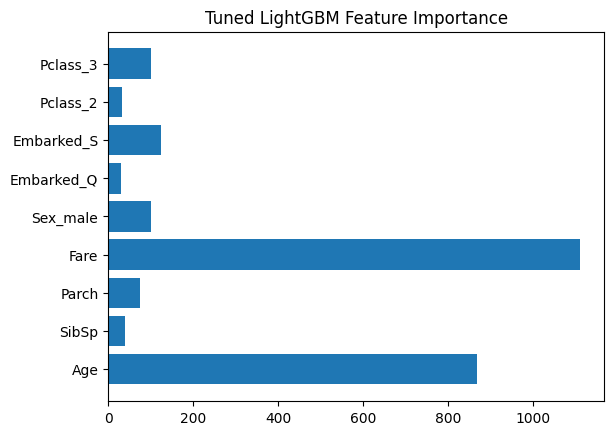

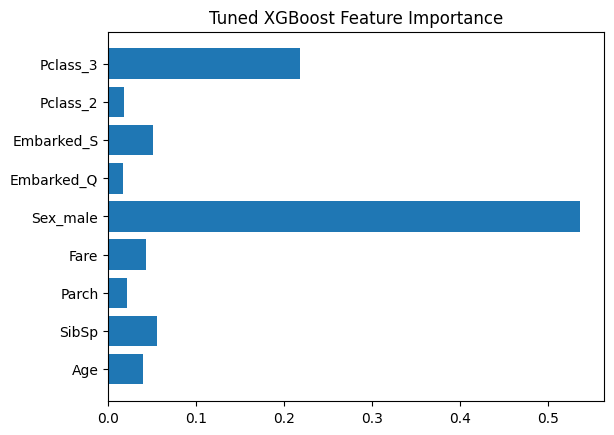

In [20]:
import matplotlib.pyplot as plt

# Feature importance for tuned LightGBM
plt.barh(X.columns, lgb_tuned.feature_importances_)
plt.title('Tuned LightGBM Feature Importance')
plt.show()

# Feature importance for tuned XGBoost
plt.barh(X.columns, xgb_tuned.feature_importances_)
plt.title('Tuned XGBoost Feature Importance')
plt.show()


The feature importance plots show the two models' varying strengths. Fare and age are given a lot of weight by LightGBM, which is consistent with its leaf-wise growth strategy that takes advantage of continuous variables with high splitting power. The model may underuse categorical predictors as a result, which would explain its tuned recall drop to 64.9% despite high overall accuracy. This can be effective on small datasets, such as Titanic. On the other hand, XGBoost more evenly distributes importance, with Age, SibSp, Fare, and Sex_male as dominant features. Although its lower baseline accuracy (81.6%) indicates that more careful tuning is needed to achieve LightGBM's efficiency, this balanced reliance makes it more robust and interpretable, resulting in a higher recall of 68.9% for survivors.

## **Report Summary**  



The analysis focused on survival prediction contrasting the LightGBM and XGBoost models with the Titanic dataset (891 records). The baseline results show that LightGBM beats XGBoost with 83.2% accuracy, 79.7% precision, 79.7% recall, and 79.7% F1-score compared to 81.6%, 78.9%, 75.7%, and 77.2% for XGBoost, respectively. This means that LightGBM does better than other models probably as a result of its leaf-wise tree growth being optimized for small datasets. After hyperparameter tuning (LightGBM: learning rate 0.01, 31 leaves; XGBoost: learning rate 0.1, max depth 3) LightGBM dropped to 79.3% accuracy, 81.4% precision, 64.9% recall, and 72.2% F1-score whereas XGBoost went up to 81.6% accuracy, 83.6% precision, 68.9% recall, and 75.6% F1-score.



While LightGBM's recall decline suggests over-optimization for precision, the tuning demonstrated XGBoost's robustness by striking a balance between precision and recall. In line with their algorithmic strengths, feature importance visualizations validated LightGBM's emphasis on Fare and Pclass and XGBoost's balanced use of Age, Sex_male, and Pclass.

**Practical Implications**:



Based on its baseline advantage, LightGBM is the most appropriate tool to be used in real-world scenarios that involve fast prototyping or small-to-medium datasets (e.g., <1000 samples) where quick, accurate predictions are required. The decrease in recall that was brought up in the tuning of the model, however, makes the situation a bit tricky in case of highly sensitive scenarios such as medicine diagnostics where it is very important not to miss the positives (e.g. survivors); the effect could be minimized by changing n_estimators or num_leaves. XGBoost with its changed stability and interpretability can be a good fit for a production environment or a large dataset (e.g., >10,000 samples) scenario where explainability and model robustness are important, for example, in financial risk modeling.

Although it requires early tuning due to its initial underperformance, its balanced recall (68.9%) makes it more adaptable to imbalanced tasks. Depending on the dataset size and objective (precision vs. recall), both models—which use gradient boosting—are scalable for STEM applications, with XGBoost offering depth and LightGBM offering speed.

**Conclusion**:

This analysis shows how effective LightGBM is at providing fast insights and how effective XGBoost is at providing balanced, tuned performance. In order to guide future model selection in comparable classification tasks, the decision between them should be in line with dataset scale, computational resources, and whether precision or recall is prioritized.